In [79]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_style('whitegrid')

sys.path.append("../")
from utility.ar1 import AR1
from utility.ar import AR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Distribution

<AxesSubplot: >

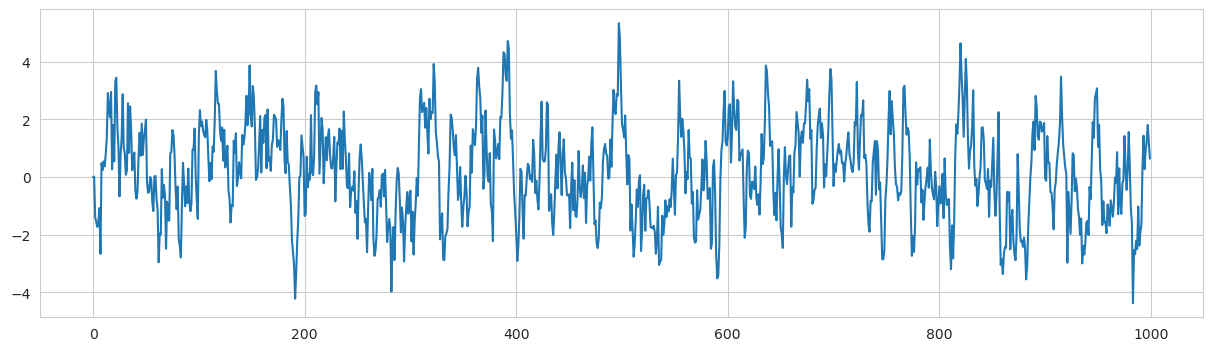

In [140]:
ar = AR1(0.8, var=1)
trace = ar.simulate(0, 1000)

trace.plot(figsize=(15, 4))

<AxesSubplot: >

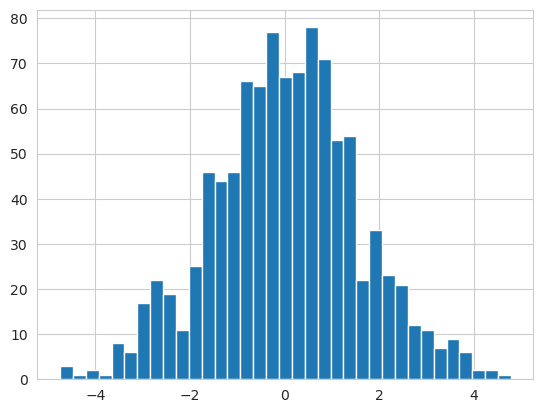

In [7]:
trace.hist(bins=35)

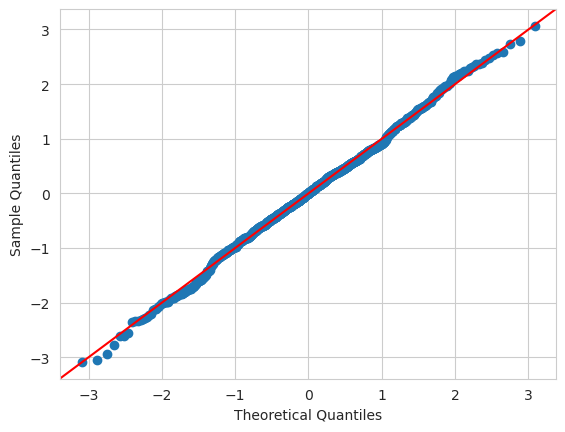

In [85]:
_ = sm.qqplot(trace, line='45', fit=True)

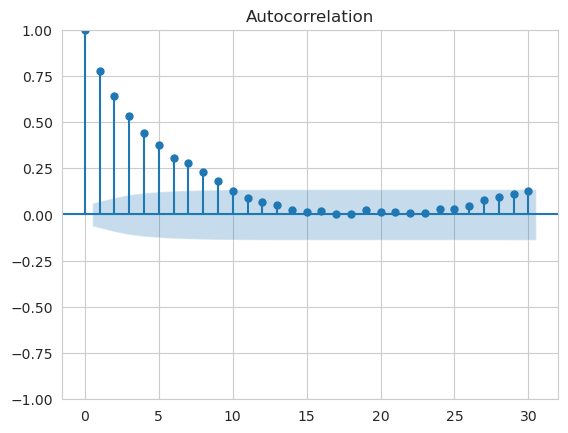

In [139]:
_ = sm.graphics.tsa.plot_acf(trace)

### Strict Stationarity

In [21]:
x1 = trace[0:250]
x2 = trace[749:]

<AxesSubplot: >

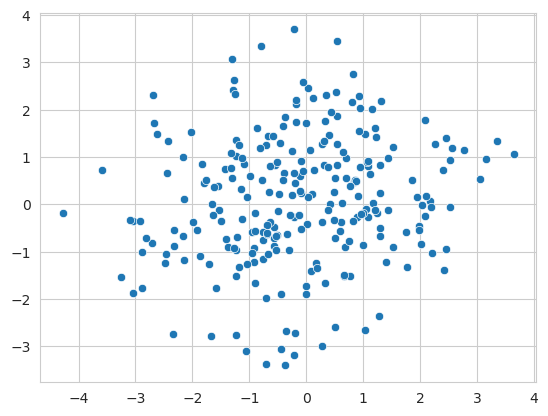

In [28]:
sns.scatterplot(x=x1.values, y=x2.values)

<AxesSubplot: ylabel='Density'>

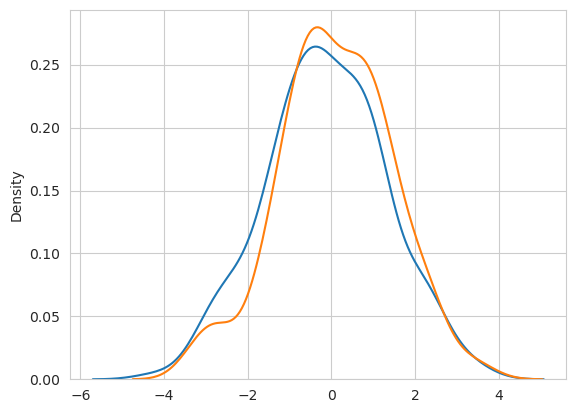

In [31]:
sns.kdeplot(x1)
sns.kdeplot(x2)

### SOI Index

In [2]:
soi = pd.read_table("soi.txt", names=['soi']).soi

<AxesSubplot: >

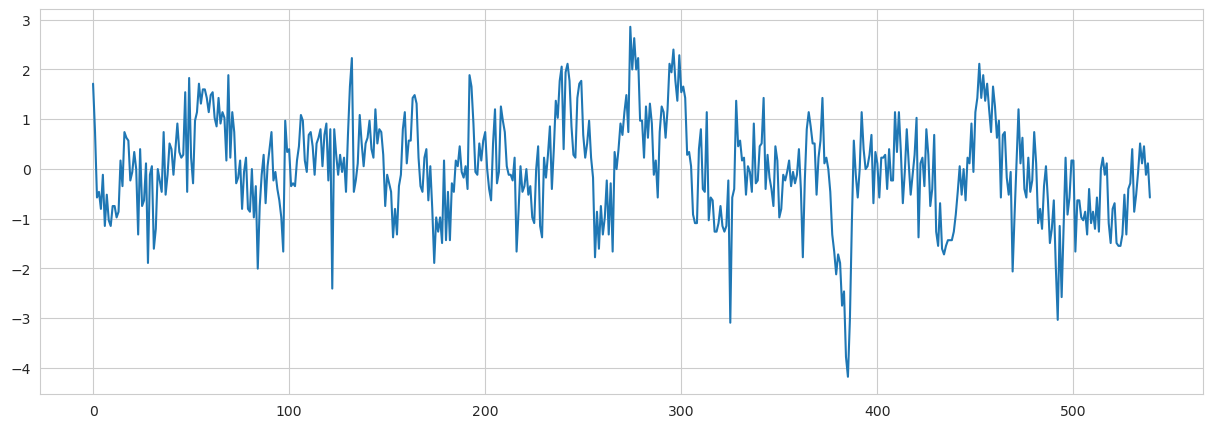

In [53]:
soi.plot(figsize=(15, 5))

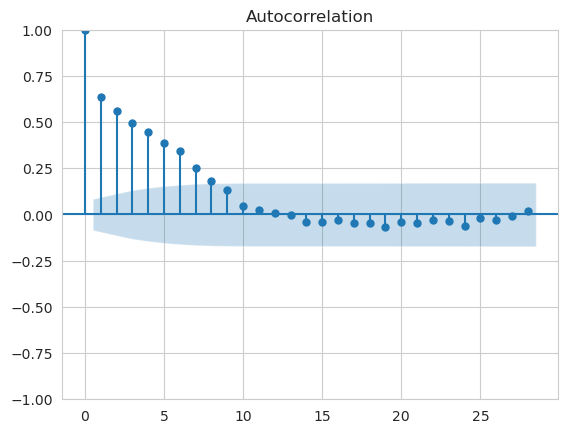

In [50]:
_ = sm.graphics.tsa.plot_acf(soi)

In [63]:
y = soi.iloc[1:].values
x = soi.iloc[:-1].values
ols = sm.OLS(y, x).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.410
Model:                            OLS   Adj. R-squared (uncentered):              0.409
Method:                 Least Squares   F-statistic:                              373.4
Date:                Sat, 21 Jan 2023   Prob (F-statistic):                    1.41e-63
Time:                        19:20:01   Log-Likelihood:                         -621.28
No. Observations:                 539   AIC:                                      1245.
Df Residuals:                     538   BIC:                                      1249.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6385      0.033     19.323      0.000       0.574       0.703
==============================================================================
Omnibus:                       13.507   Durbin-Watson:                   2.321
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.242
Skew:                          -0.261   Prob(JB):                     0.000180
Kurtosis:                       3.704   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

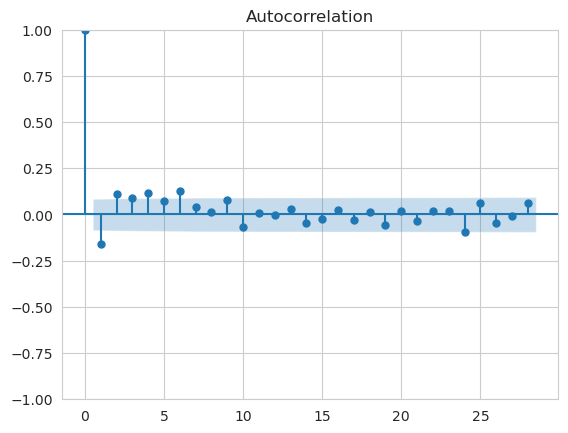

In [98]:
error = y - ols.params[0] * x
_ = sm.graphics.tsa.plot_acf(error)

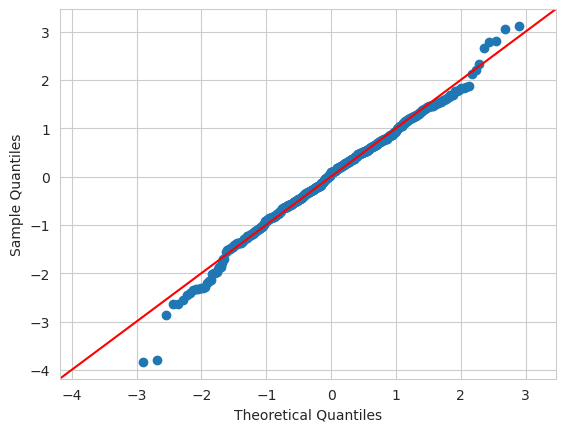

In [99]:
_ = sm.qqplot(error, line='45', fit=True)

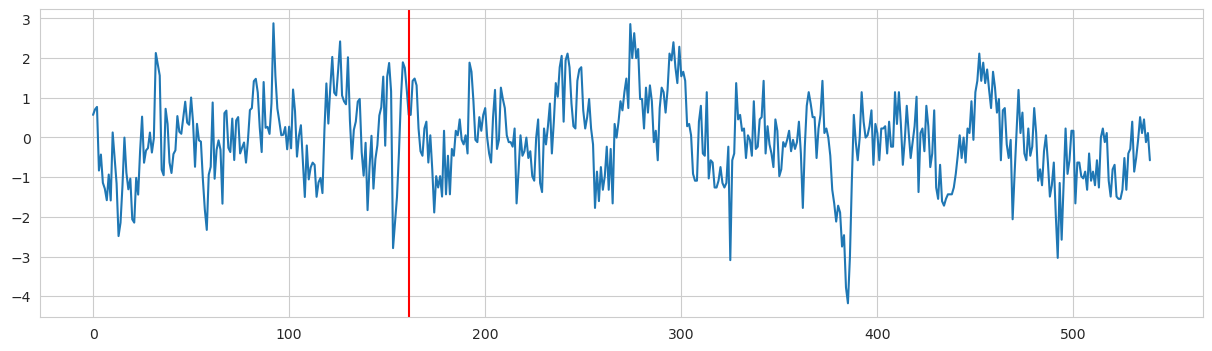

In [147]:
soi_simu = AR1(ols.params[0], error.var())

sr = soi.copy()
end_point = np.random.randint(0, 540)
sr[:end_point] = soi_simu.simulate(x0=sr[end_point], length=end_point)

fig, ax = plt.subplots(figsize=(15, 4))
sr.plot(ax=ax)
ax.axvline(end_point, color='red')

### Reference Bayes Posterior

In [80]:
model = AR(lags=1).fit(soi)

In [83]:
h = 1000

vars_post = model.sample_innovation_var(10000)
coeff_post = model.sample_coeff(vars_post).ravel()
yhat_post = model.predict(h, coeff_post, vars_post)

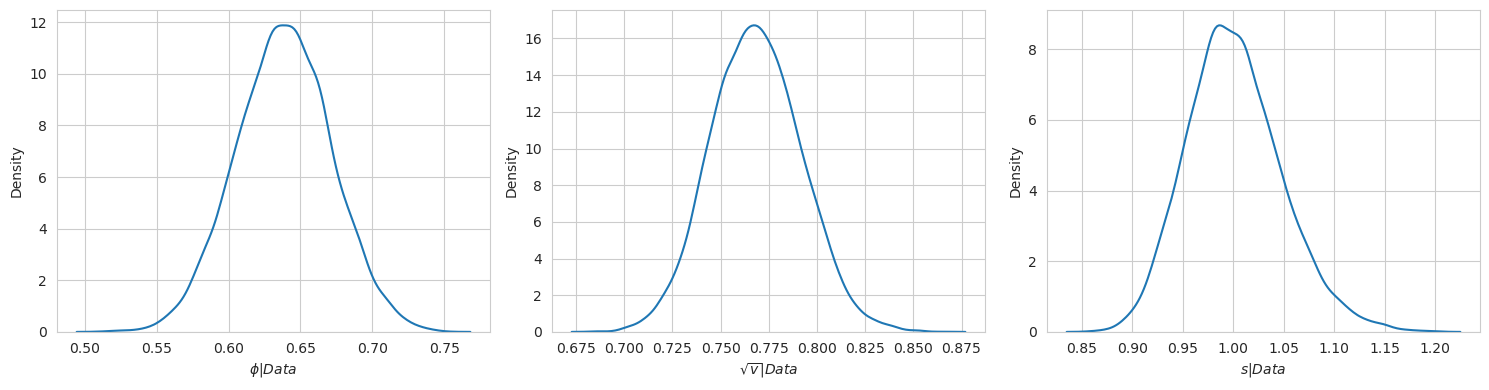

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

sns.kdeplot(coeff_post, ax=ax[0])
sns.kdeplot(np.sqrt(vars_post), ax=ax[1])
sns.kdeplot(np.sqrt(vars_post / (1 - coeff_post**2)), ax=ax[2])

ax[0].set_xlabel("$\phi|Data$")
ax[1].set_xlabel("$\sqrt{v}|Data$")
ax[2].set_xlabel("$s|Data$")

fig.tight_layout()

<AxesSubplot: >

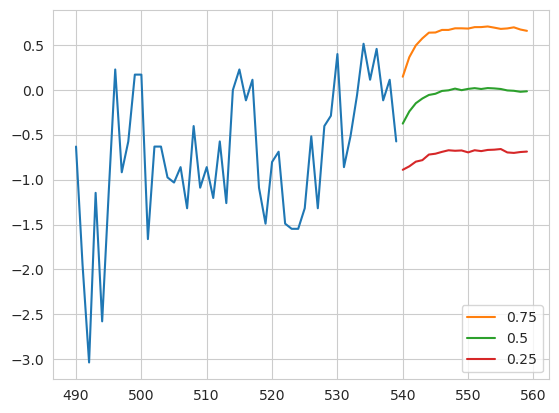

In [85]:
yhat = pd.DataFrame(yhat_post.T).quantile((0.75, 0.5, 0.25)).T
yhat.index = np.arange(soi.shape[0], soi.shape[0]+h)

ax = soi.iloc[-50:].plot()
yhat.iloc[:20].plot(ax=ax)

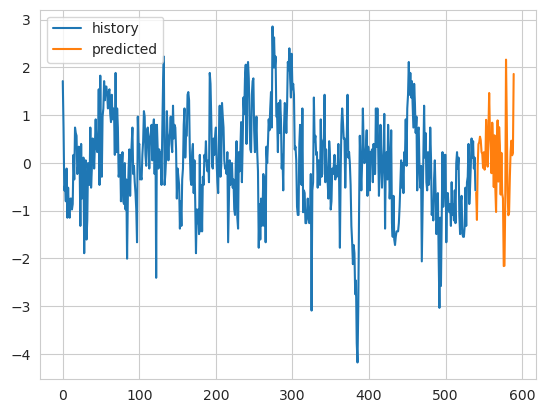

In [99]:
yhat = pd.DataFrame(yhat_post)
yhat.index = np.arange(soi.shape[0], soi.shape[0]+h)

ax = soi.plot(label='history')
yhat.sample(axis=1).iloc[:50, 0].plot(ax=ax, label='predicted')
ax.legend()